In [1]:
from forse.networks.dcgan import *
import matplotlib.pyplot as plt
from forse.mmmtools import *

Using TensorFlow backend.


In [2]:
dcgan = DCGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/DCGAN/tests', img_size=(64, 64))

In [4]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/models/zoomed/'
dcgan.discriminator = load_model(dir_models+'discrim_75000.h5')
dcgan.generator = load_model(dir_models+'generat_75000.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/usr/common/software/tensorflow/gpu-tensorflow/1.13.1-py36/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
accs = np.load(dir_models+'acc_dreal_dfake_75000.npy')

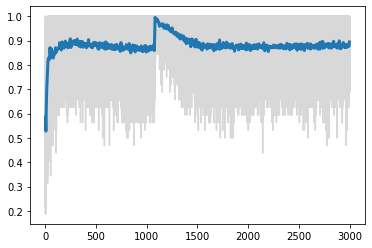

In [6]:
data = (accs[:,1]+accs[:,0])/2.
x_binned, data_binned = bin_history(data, bins=100)
plt.plot(np.arange(len(data))/25., data, color='grey', alpha=0.3)
plt.plot(x_binned/25, data_binned, lw=3)

In [8]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file = 'training_set_1000patches_10x10def_T_hr_1deg_lr_5deg_Npix64_set2.npy'
X_train, X_test, Y_train, Y_test = dcgan.load_training_set(training_path+training_file)
gen_imgs_test = dcgan.generator.predict(X_test)
gen_imgs_train = dcgan.generator.predict(X_train)

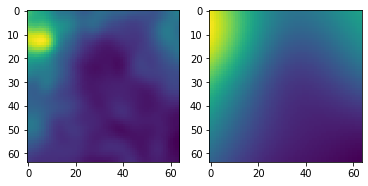

In [9]:
N=92
plt.subplot(121)
plt.imshow(Y_train[N, :, :, 0]+X_train[N, :, :, 0])
plt.subplot(122)
plt.imshow(X_train[N, :, :, 0])

In [10]:
def normalize_back(image, edges):
    nimage = (image+1)/2.*(edges[1]-edges[0])+edges[0]
    return(nimage)

In [13]:
patch_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
Ys, Xs = np.load(patch_path+'training_set_1000patches_10x10def_T_hr_1deg_lr_5deg_Npix64_set2.npy')
Yl, Xl = np.load(patch_path+'training_set_1000patches_10x10def_T_hr_1deg_lr_5deg_Npix320_set2.npy')
Xl_zoom = np.zeros((25*len(Yl), 64, 64))
X_edges = []
for i in range(40):
    Xl_zoom[i*25:(i+1)*25] = divide_image(Yl[i])
X, Y = Xl_zoom, Ys-Xs
Y = np.transpose(Y[:1000])
X = np.transpose(X[:1000])
for i in range(Y.shape[-1]):
    X_edges.append([X[:,:,i].min(), X[:,:,i].max()])
    Y[:,:,i] = 2*(Y[:,:,i]-X[:,:,i].min())/(X[:,:,i].max()-X[:,:,i].min())-1
    X[:,:,i] = 2*(X[:,:,i]-X[:,:,i].min())/(X[:,:,i].max()-X[:,:,i].min())-1
x_train, x_test = split_training_set(X)
y_train, y_test = split_training_set(Y)
X_edges = np.array(X_edges)    

In [14]:
gen_imgs_test = dcgan.generator.predict(x_test)
gen_imgs_train = dcgan.generator.predict(x_train)

In [15]:
bnormed_train = np.copy(x_train)
bnormed_gen = np.copy(gen_imgs_train)
for i in range(800):
    bnormed_train[i] = normalize_back(x_train[i], X_edges[i])
    bnormed_gen[i] = normalize_back(gen_imgs_train[i]+x_train[i], X_edges[i])

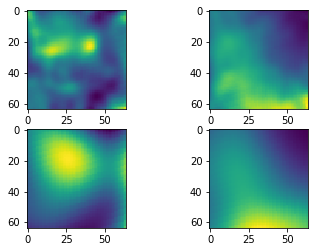

In [16]:
N = 0
plt.subplot(221)
plt.imshow(bnormed_gen[N, :, :, 0])
plt.subplot(222)
plt.imshow(bnormed_gen[N+1, :, :, 0])
plt.subplot(223)
plt.imshow(bnormed_train[N, :, :, 0])
plt.subplot(224)
plt.imshow(bnormed_train[N+1, :, :, 0])

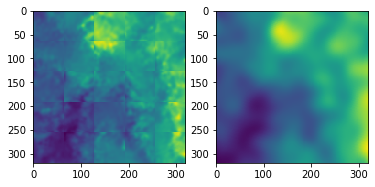

In [17]:
a = 650
b = a+25
small_scale = unify_image(bnormed_gen[a:b])
plt.subplot(121)
plt.imshow((small_scale))
large_scale = unify_image(bnormed_train[a:b])
plt.subplot(122)
plt.imshow((large_scale))

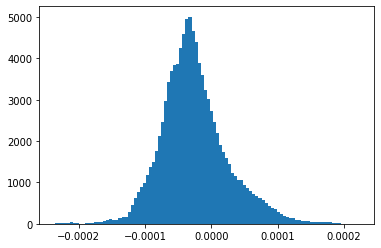

In [18]:
h = plt.hist(small_scale.flatten() - large_scale.flatten(), bins=100)